<a href="https://colab.research.google.com/github/rohitnikam1/Portfolio_Optimization/blob/master/modern_portfolio_theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementation of Modern Portfolio Theory**
## **Import relevant packages**
Ideally, one should set up their own virtual environment and determine the versions of each library that they are using. Here, we will assume that the colaboratory environment has some shared environment with access to common python libraries and the ability to install other required libraries.

In [2]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 48.7 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=05e15a88fc849af7604564999772298e0ed478d116a3a0685603d5ce67802b4d
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [62]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import datetime
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


# Set formatting
yf.pdr_override()
%matplotlib inline
sns.set()
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## **Get the data**
Below we write a function to get the close value data for a given stock.

In [5]:
def get_data(stocks, start, end):
  '''Import the stock data'''
  stockData = pdr.get_data_yahoo(stocks, start=start, end=end)
  stockData = stockData['Close']
  return stockData

We in fact need returns of the close value of each stock, which we calculate below.

In [6]:
def get_returns(stockData):
  '''Get stock returns from stock data'''
  returns = stockData.pct_change()
  return returns[1:]

We now fill our stock inventory with some stocks. We have Goldman Sachs, Tesla and Manchester United. We also need to mention the time period for which we intend to gather the stock data for these tickers, which we do by defining start date and end date.

In [7]:
stocklist = ['GS', 'TSLA', 'MANU']

endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=365)

The descriptive statistics of the obtained returns data can now be calculated in terms of the mean returns and the covariance matrix as follows:

In [8]:
def get_stats(returns):
    '''Return mean and covariance matrix of returns'''
    meanReturns, covMatrix = returns.mean(), returns.cov()
    return meanReturns, covMatrix 

The performance of a portfolio consisting of these stocks and for certain weights can be quantified in terms of the portfolio returns and portfolio variance (or standard deviation), given as:

In [9]:
def portfolioPerformance(weights, meanReturns, covMatrix):
    '''Portfolio returns and std deviation for given weights'''
    portRet = np.dot(weights, meanReturns)*252
    portStd = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))*252)
    return portRet, portStd

It's now time to initialize the weights vector.

In [115]:
# Initializing weights
weights = np.random.rand((len(stocklist)))
weights = weights / np.sum(weights)
print(f'Initialized weights: {weights}')

# Obtaining the returns data for given tickers and time duration
returns = get_returns(get_data(stocklist, start=startDate, end=endDate))
display(returns.head())

# Calculating the returns stats and the corresponding portfolio performance based on weights
meanReturns, covMatrix = get_stats(returns)
portRet, portStd = portfolioPerformance(weights, meanReturns, covMatrix)
print(f'portRet: {portRet*100:.1f}', f'portStd: {portStd*100:.1f}')

Initialized weights: [0.18625424 0.45906732 0.35467844]
[*********************100%***********************]  3 of 3 completed


,GS,MANU,TSLA
Date,,,
2020-10-16,-0.011457,-0.009326,-0.020518
2020-10-19,-0.002522,-0.023896,-0.020106
2020-10-20,0.011376,-0.011869,-0.020635
2020-10-21,-0.024612,0.093093,0.001659
2020-10-22,0.012271,-0.026099,0.007453


portRet: 51.7 portStd: 28.1


The historical relationship between returns of two stocks is given by the correlation coefficient. It may provide a guide to the future relationship between the assets as well. Below we calculate such correlation matrix for our stocks.

In [11]:
def get_correlation(returns):
    '''
    Get stock returns and return Pearson correlation coeffiecient of each pair
    '''
    corr = returns.corr(method='pearson')
    sns.set_style("white")
    mask = np.triu(np.ones_like(corr, dtype=bool))   # Generate a mask for the upper triangle

    s = sns.heatmap(corr, 
                    annot = True, 
                    mask=mask, 
                    fmt = '.2f', 
                    cmap = 'RdBu',
                    vmin = -1,
                    vmax = 1,
                    annot_kws={"fontsize":14})
    s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 14)
    s.set_xticklabels(s.get_xticklabels(), rotation = 0, fontsize = 14)
    plt.title('Correlation Heatmap', fontsize = 20)

    plt.show()
    plt.close()
    
    return

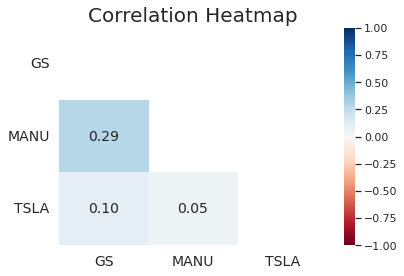

In [12]:
get_correlation(returns=returns)

We now optimize our portfolio for **Maximum Sharpe Ratio**, i.e., the weights that give the highest return for a volatility.

## **Optimize the portfolio for the maximum Sharpe Ratio**
![](https://drive.google.com/uc?export=view&id=1dQvyr3lTvSYFt_iW0j7-l-sZvc-VGZil)

In [13]:
# Objective Function: Negative Sharpe Ratio
def negativeSR(weights, meanReturns, covMatrix, riskFreeRate = 0):
    portRet, portStd = portfolioPerformance(weights, meanReturns, covMatrix)
    return -(portRet - riskFreeRate)/portStd

In [14]:
# Minimizing the negative Sharpe ratio by altering weights, with full investment constraint

def maxSR(meanReturns, covMatrix, riskFreeRate = 0, constraintSet = (0,1)):
    '''
    Minimize the negative Sharpe Ratio by altering the portfolio weights.
    constraintSet is a tuple of lower and upper bound for the weight of each asset
    '''
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1}) #fully invested
    bounds = tuple(constraintSet for asset in range(numAssets))   #long only
    results = opt.minimize(negativeSR, numAssets*[1./numAssets], args=args, method='SLSQP',
                           constraints=constraints, bounds=bounds)
    return results

In [118]:
# Collect relevant results
result = maxSR(meanReturns, covMatrix)
maxSharpeRatio, weights = -result['fun'], result['x']
print(f'Max Sharpe Ratio: {maxSharpeRatio*100:.1f}%')
print(f'Weights that give Max SR: {np.round(weights*100, 1)}%')

Max Sharpe Ratio: 287.8%
Weights that give Max SR: [80.8  0.  19.2]%


So it looks like investing $80.8$%, and $19.2$% of our capital in Goldman Sachs and Tesla stocks gives us the highest return to volatility ratio. The model suggests not to invest in Manchester United at the moment.

## **Maximize the quadratic utility**
Von Neumann-Morgenstern utility theory suggests that for making rational decisions under uncertain market conditions, one should refer to a utility function for the capital. The optimal portfolio thus then solves the expected utility maximization problem. Below is a quadratic utility maximization problem. 
![](https://drive.google.com/uc?export=view&id=156JCkwP4zPOJ1HArnOsDktCWWLK0YvYk)

In [16]:
# Objective function: Negative quadratic utility
def quadUtil(weights, meanReturns, covMatrix, riskAversion = 0.5):
    portRet, portStd = portfolioPerformance(weights, meanReturns, covMatrix)
    return - portRet + riskAversion*portStd**2

In [17]:
def maxQuadUtil(meanReturns, covMatrix, riskAversion = 0.5, constraintSet = (0,1)):
    '''
    Minimize the negative quadratic utility.
    '''
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskAversion)
    constraints = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1}) #fully invested
    bounds = tuple(constraintSet for asset in range(numAssets))   #long only
    results = opt.minimize(quadUtil, numAssets*[1./numAssets], args=args, method='SLSQP',
                           constraints=constraints, bounds=bounds)
    return results

In [113]:
# Collecting relevant results
result = maxQuadUtil(meanReturns, covMatrix)
maxQU, maxUtilweights = -result['fun'], result['x']
print(f'Max Utility: {maxQU*100:.1f}%')
print(f'Weights that give Max Utility: {np.round(maxUtilweights*100, 1)}%')

Max Utility: 68.3%
Weights that give Max Utility: [64.  0. 36.]%


## **Minimize Volatility**
We now construct a portfolio with a minimum risk, i.e., minimum variance. The optimization problem can then be expressed as:
![](https://drive.google.com/uc?export=view&id=1SpAGm4Jny-losWznbv1wTS67ZglfoSEn)

In [19]:
# Objective function: Portfolio variance
def portVar(weights, meanReturns, covMatrix):
    '''Returns only the portfolio std deviation from stock data'''
    return portfolioPerformance(weights, meanReturns, covMatrix)[1]

In [20]:
def minimizeVariance(meanReturns, covMatrix, constraintSet = (0,1)):
    '''Minimize the portfolio variance. Returns the minima of portfolio std-mean curve'''
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1}) #fully invested
    bounds = tuple(constraintSet for asset in range(numAssets))   #long-only
    results = opt.minimize(portVar, numAssets*[1./numAssets], args=args, method='SLSQP',
                           constraints=constraints, bounds=bounds)
    return results

In [117]:
# Collecting relevant results
minVarResult = minimizeVariance(meanReturns, covMatrix)
minVar, minVarweights = minVarResult['fun'], minVarResult['x']
print(f'Min Variance: {minVar*100:.1f}%')
print(f'Weights that give Min Variance: {np.round(minVarweights*100, 1)}%')

Min Variance: 23.1%
Weights that give Min Variance: [62.  23.2 14.7]%


## **Mimimize volatility under returns constraint: The Efficient Frontier**
In modern portfolio theory, **The Efficient Frontier** is a set of portfolios with lowest possible standard deviation of target returns (i.e., the risk), for the target expected returns. The optimization problem then changes to:

![](https://drive.google.com/uc?export=view&id=1g34JcyVHFBpnpFWs9Z80quQxFZAP0b-G)

In order to plot the efficient frontier, we first solve the above optimization problem for a single value of the returns in constraints. The returns constraints are then changed for different target returns to get corresponding weights that minimize the portfolio variance.

In [22]:
# Objective function: Portfolio returns
def portRet(weights, meanReturns, covMatrix):
    '''Returns only the portfolio returns from stock data'''
    return portfolioPerformance(weights, meanReturns, covMatrix)[0]

In [23]:
def efficient_opt(meanReturns, covMatrix, returnTarget, constraintSet=(0,1)):
    '''For each return target, minimize the portfolio variance'''
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type':'eq',   'fun': lambda x: np.sum(x) - 1}, #fully invested
                   {'type':'ineq', 'fun': lambda x: portRet(x,meanReturns,covMatrix) - returnTarget}) #fixed target return
    bounds = tuple(constraintSet for asset in range(numAssets))
    results = opt.minimize(portVar, numAssets*[1./numAssets], args=args, method='SLSQP',
                           constraints=constraints, bounds=bounds)
    return results

The above function is now used to get portfolio variances for multiple target returns, as shown in the function below:

In [25]:
def calculatedResults(meanReturns, covMatrix, riskFreeRate=0, constraintSet=(0,1)):
    '''
    Read in mean, covariance matrix and other financial information and 
    return max Sharpe Ratio, Min Volatility and efficient frontier
    '''
    # Max Sharpe Ratio Portfolio: return corresponding returns, std and weights
    maxSR_weights = maxSR(meanReturns, covMatrix)['x']
    maxSR_returns, maxSR_std = portfolioPerformance(maxSR_weights, meanReturns, covMatrix)
    maxSR_allocation = pd.DataFrame(maxSR_weights, index = meanReturns.index, columns = ['Allocation'])
    maxSR_allocation['Allocation'] = [round(i*100,1) for i in maxSR_allocation['Allocation'] ]
    
    # Min Volatility Portfolio: return corresponding returns, std and weights
    minVar_weights = minimizeVariance(meanReturns, covMatrix)['x']
    minVar_returns, minVar_std = portfolioPerformance(minVar_weights, meanReturns, covMatrix)
    minVar_allocation = pd.DataFrame(minVar_weights, index = meanReturns.index, columns = ['Allocation'])
    minVar_allocation['Allocation'] = [round(i*100,1) for i in minVar_allocation['Allocation'] ]
    
    #Efficient frontier
    efficient_list = []
    targetReturns = np.linspace(minVar_returns, maxSR_returns, 20)
    
    for target in targetReturns:
        efficient_list.append(efficient_opt(meanReturns, covMatrix, target)['fun'])
        
    
    return round(maxSR_returns*100,2),  round(maxSR_std*100,2),  maxSR_allocation, \
           round(minVar_returns*100,2), round(minVar_std*100,2), minVar_allocation,\
           efficient_list, targetReturns

The results from the function above, i.e., locations of maximum Sharpe ratio, minimum volatility and efficient frontier array will be used in the plotting function below:

In [106]:
def EF_graph(meanReturns, covMatrix, riskFreeRate=0, constraintSet=(0,1)):
    """
    Return a graph ploting the min vol, max sr and efficient frontier
    """
    maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std,\
    minVol_allocation, efficientList, targetReturns = calculatedResults(meanReturns, covMatrix, riskFreeRate, constraintSet)

    sns.set()
    fig, ax = plt.subplots(1,1, figsize = (8,6))

    x = [round(ef_std*100, 2) for ef_std in efficientList]
    y = [round(target*100, 2) for target in targetReturns]
    ax.plot(x, y, label = 'Efficient Frontier', linestyle = '--', linewidth = 3, color = 'black')

    ax.scatter([maxSR_std], [maxSR_returns], label = 'Maximum Sharpe Ratio', s = 100, c = ['red'])
    ax.scatter([minVol_std], [minVol_returns], label = 'Minimum Volatility', s = 100, c = ['blue'])

    ax.legend(prop={'size': 15})
    ax.set_xlabel('Annualised Volatility (%)', size = 15)
    ax.set_ylabel('Annualised Return (%)', size = 15)
    ax.tick_params(axis='both', labelsize=15)

    plt.show()
    plt.close()
    
    return

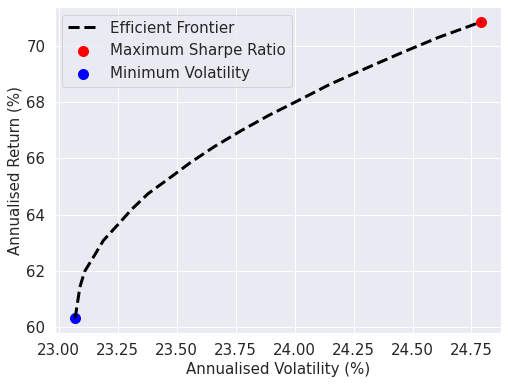

In [107]:
EF_graph(meanReturns, covMatrix)